In [6]:
%autoreload 2
from plasmapy import simulation
import astropy.units as u
import numpy as np

In [7]:
import xarray

In [8]:
from plasmapy.classes.sources.interparticle import InterParticleForces

In [9]:
eq_distance = 0.1
forces = {key: InterParticleForces(key, 100, eq_distance, 1, 100000, 7) for key in ('python', 'njit', 'njit_parallel')}

from collections import namedtuple
CustomParticle = namedtuple('custom_particle', ['mass', 'charge'])
particle = CustomParticle(mass=1 * u.dimensionless_unscaled, charge=1 * u.dimensionless_unscaled)

L = 1 * u.m
N = 128
np.random.seed(0)
x = u.Quantity(np.random.random((N, 3))*L,  u.m)
v = u.Quantity(np.zeros(x.shape, dtype=float), u.m / u.s)

from scipy import spatial
tree = spatial.cKDTree(x)
close_pairs = tree.query_pairs(eq_distance)
while close_pairs:
    for a, b in close_pairs:
        x[b] = np.random.random(3) * L
    tree = spatial.cKDTree(x)
    close_pairs = tree.query_pairs(eq_distance)

In [10]:
solutions = {engine: simulation.ParticleTracker(forces[engine], x, v, particle).run(1e-1 * u.s, dt = 1e-6 * u.s) for engine in ['njit']}

In [11]:
solutions['njit'].to_netcdf("/home/dominik/particles.nc")

In [12]:
solutions['njit']

<xarray.Dataset>
Dimensions:           (dimension: 3, particle: 128, time: 1001)
Coordinates:
  * time              (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
  * particle          (particle) int64 0 1 2 3 4 5 6 ... 122 123 124 125 126 127
  * dimension         (dimension) <U1 'x' 'y' 'z'
Data variables:
    position          (time, particle, dimension) float64 0.5488 ... 0.573
    velocity          (time, particle, dimension) float64 -0.001163 ... 19.12
    B                 (time, particle, dimension) float64 0.0 0.0 ... 0.0 0.0
    E                 (time, particle, dimension) float64 2.327e+03 ... 5.86e+04
    timestep          (time) float64 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    kinetic_energy    (time, particle) float64 7.749e-06 8.13e-05 ... 717.0
    potential_energy  (time, particle) float64 -223.3 -324.6 ... -1.704e+03
Attributes:
    particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)

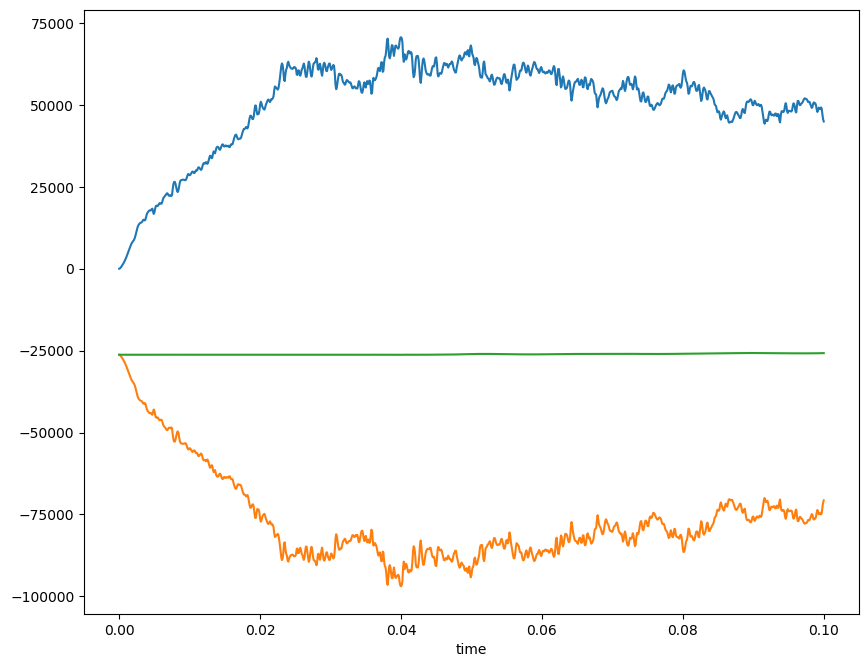

In [13]:
solutions['njit'].kinetic_energy.sum(dim='particle').plot.line()
solutions['njit'].potential_energy.sum(dim='particle').plot.line()
(solutions['njit'].potential_energy + solutions['njit'].kinetic_energy).sum(dim='particle').plot.line()

In [14]:
N_bins = 100
N_times = 1000
for solution in solutions.values():
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
    max_L = L
    bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)
        tree = spatial.cKDTree(pos)

        histograms = []
        for particle in range(N):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, N))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (4 * np.pi * dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': solution.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()


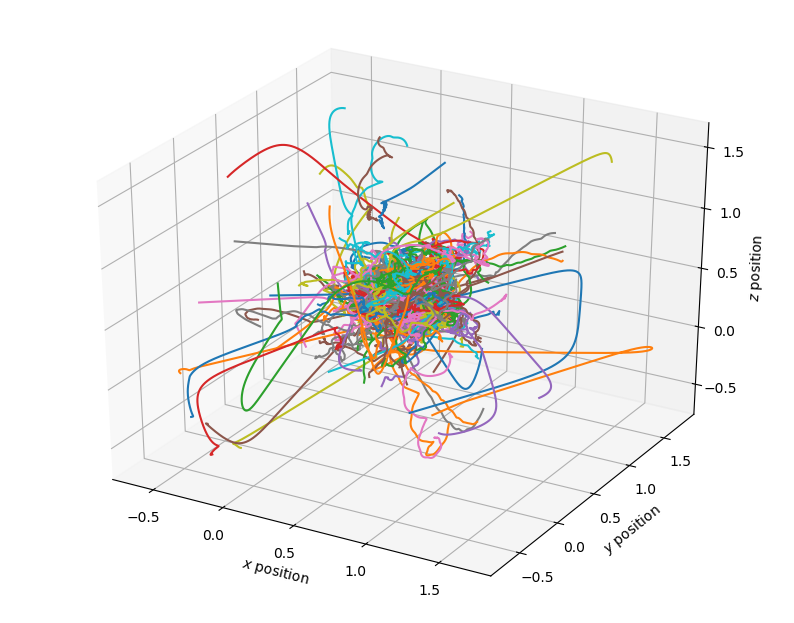

In [15]:
solution.particletracker.plot_trajectories()

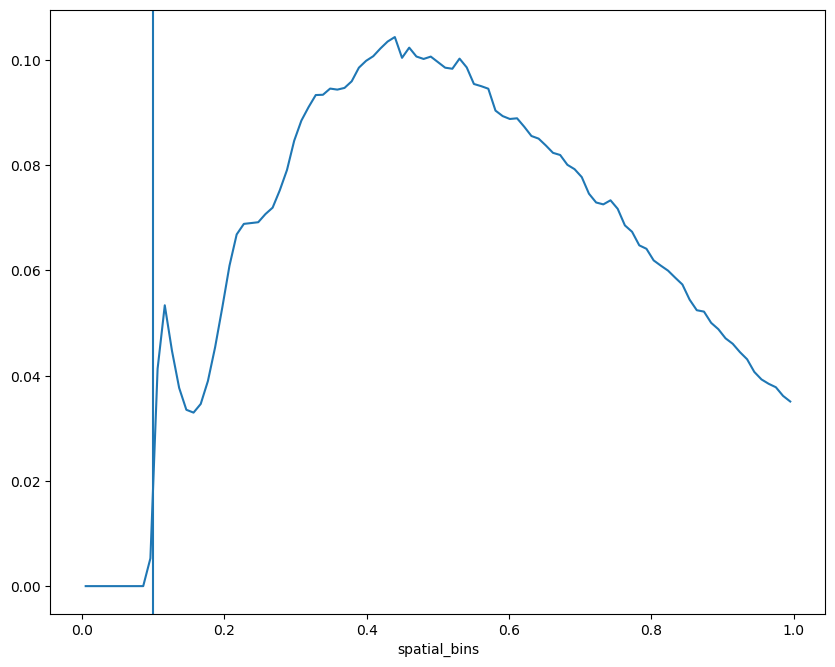

In [16]:
import matplotlib.pyplot as plt

da.isel(time=range(50, 1000)).mean(dim=['particle', 'time']).plot.line()
plt.axvline(eq_distance)

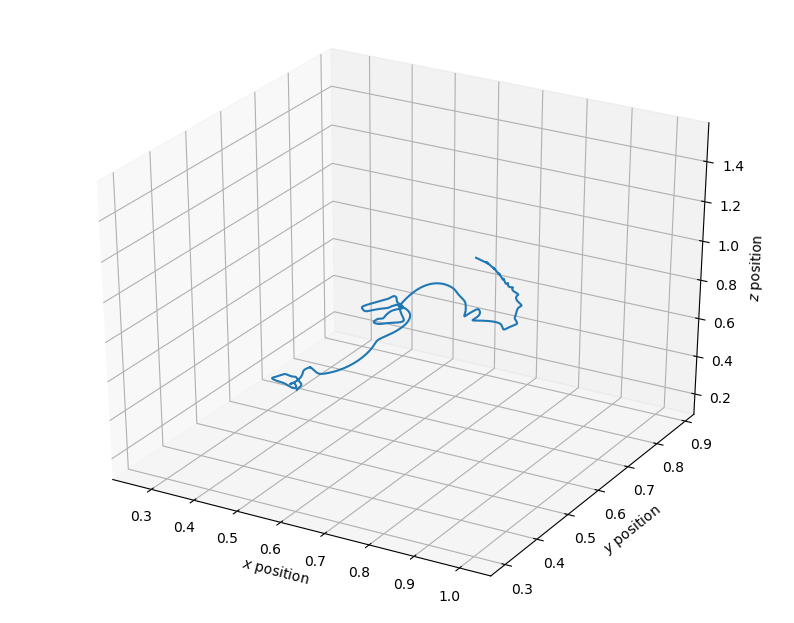

In [17]:
solution.sel(particle=[30]).particletracker.plot_trajectories()

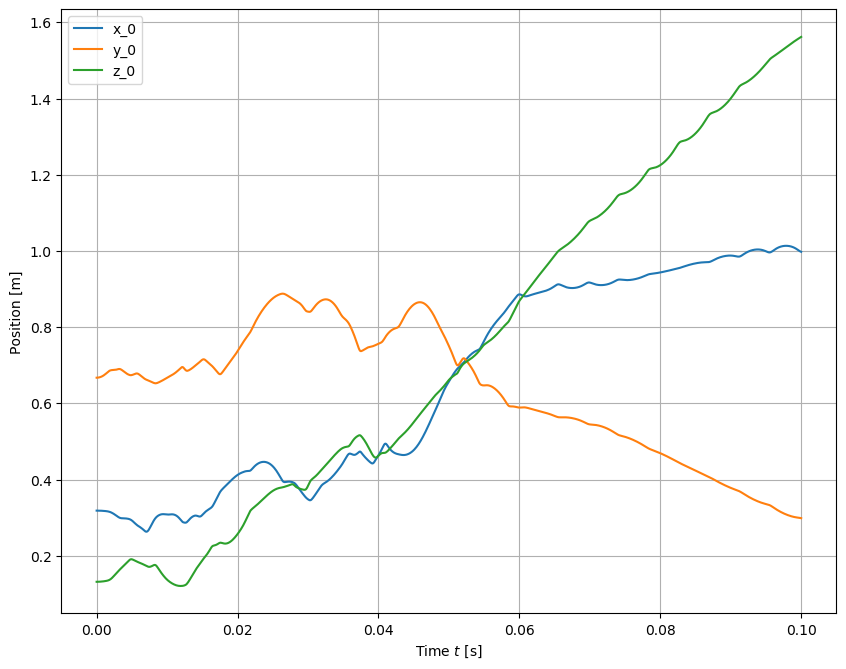

In [18]:
solution.sel(particle = [30]).particletracker.plot_time_trajectories()

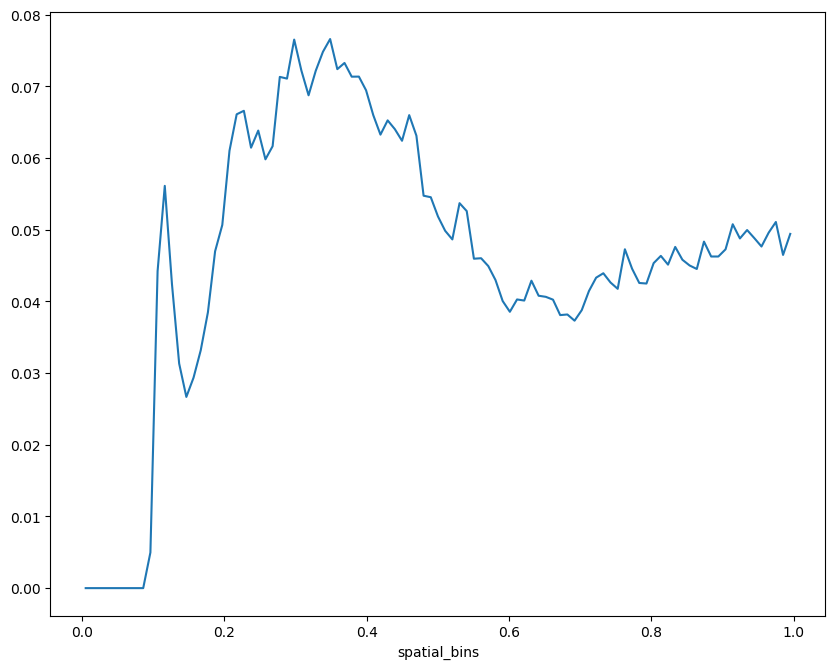

In [19]:
da.isel(time=range(900, 1000)).mean(dim=['particle', 'time']).plot.line()

In [20]:
np.array(all_histograms).shape

(1000, 128, 99)

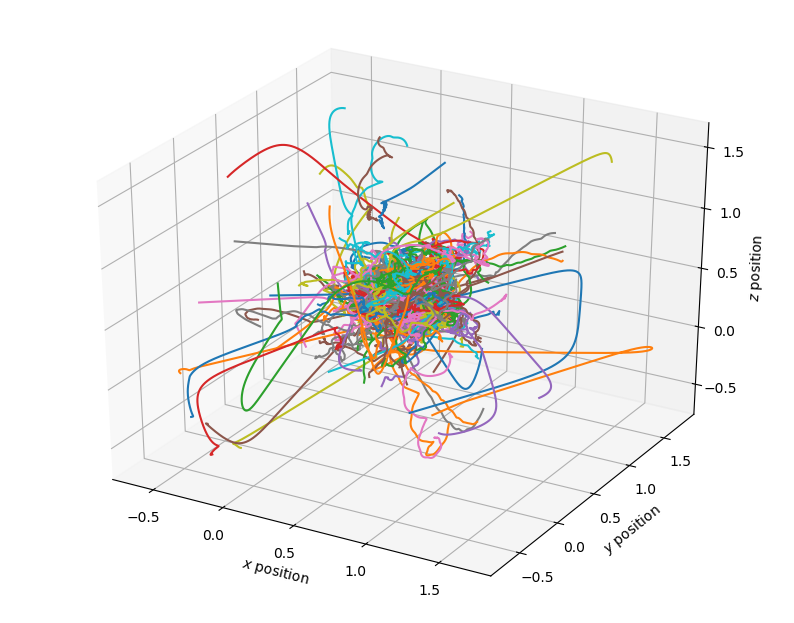

In [21]:
solution.particletracker.plot_trajectories()

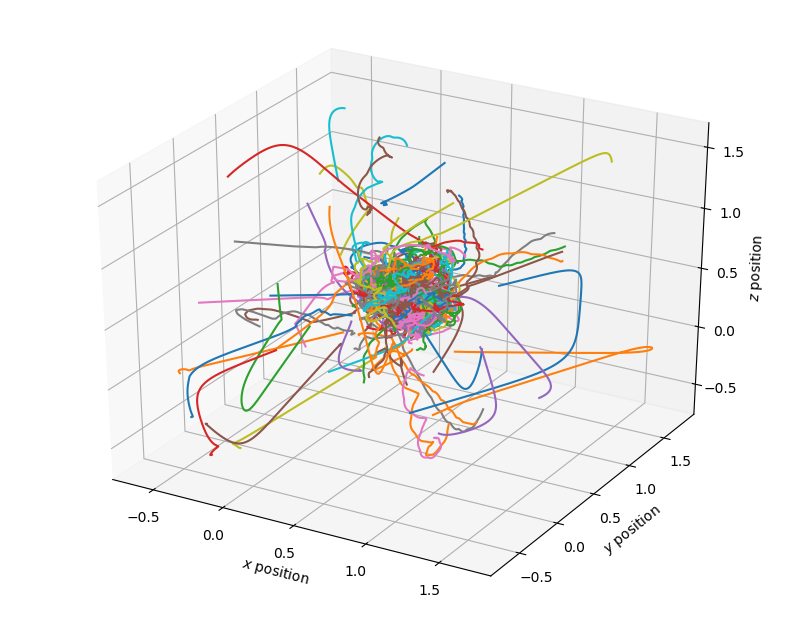

In [22]:
solution.isel(time=range(solution.time.size//10 * 4, solution.time.size // 10 * 10)).particletracker.plot_trajectories()

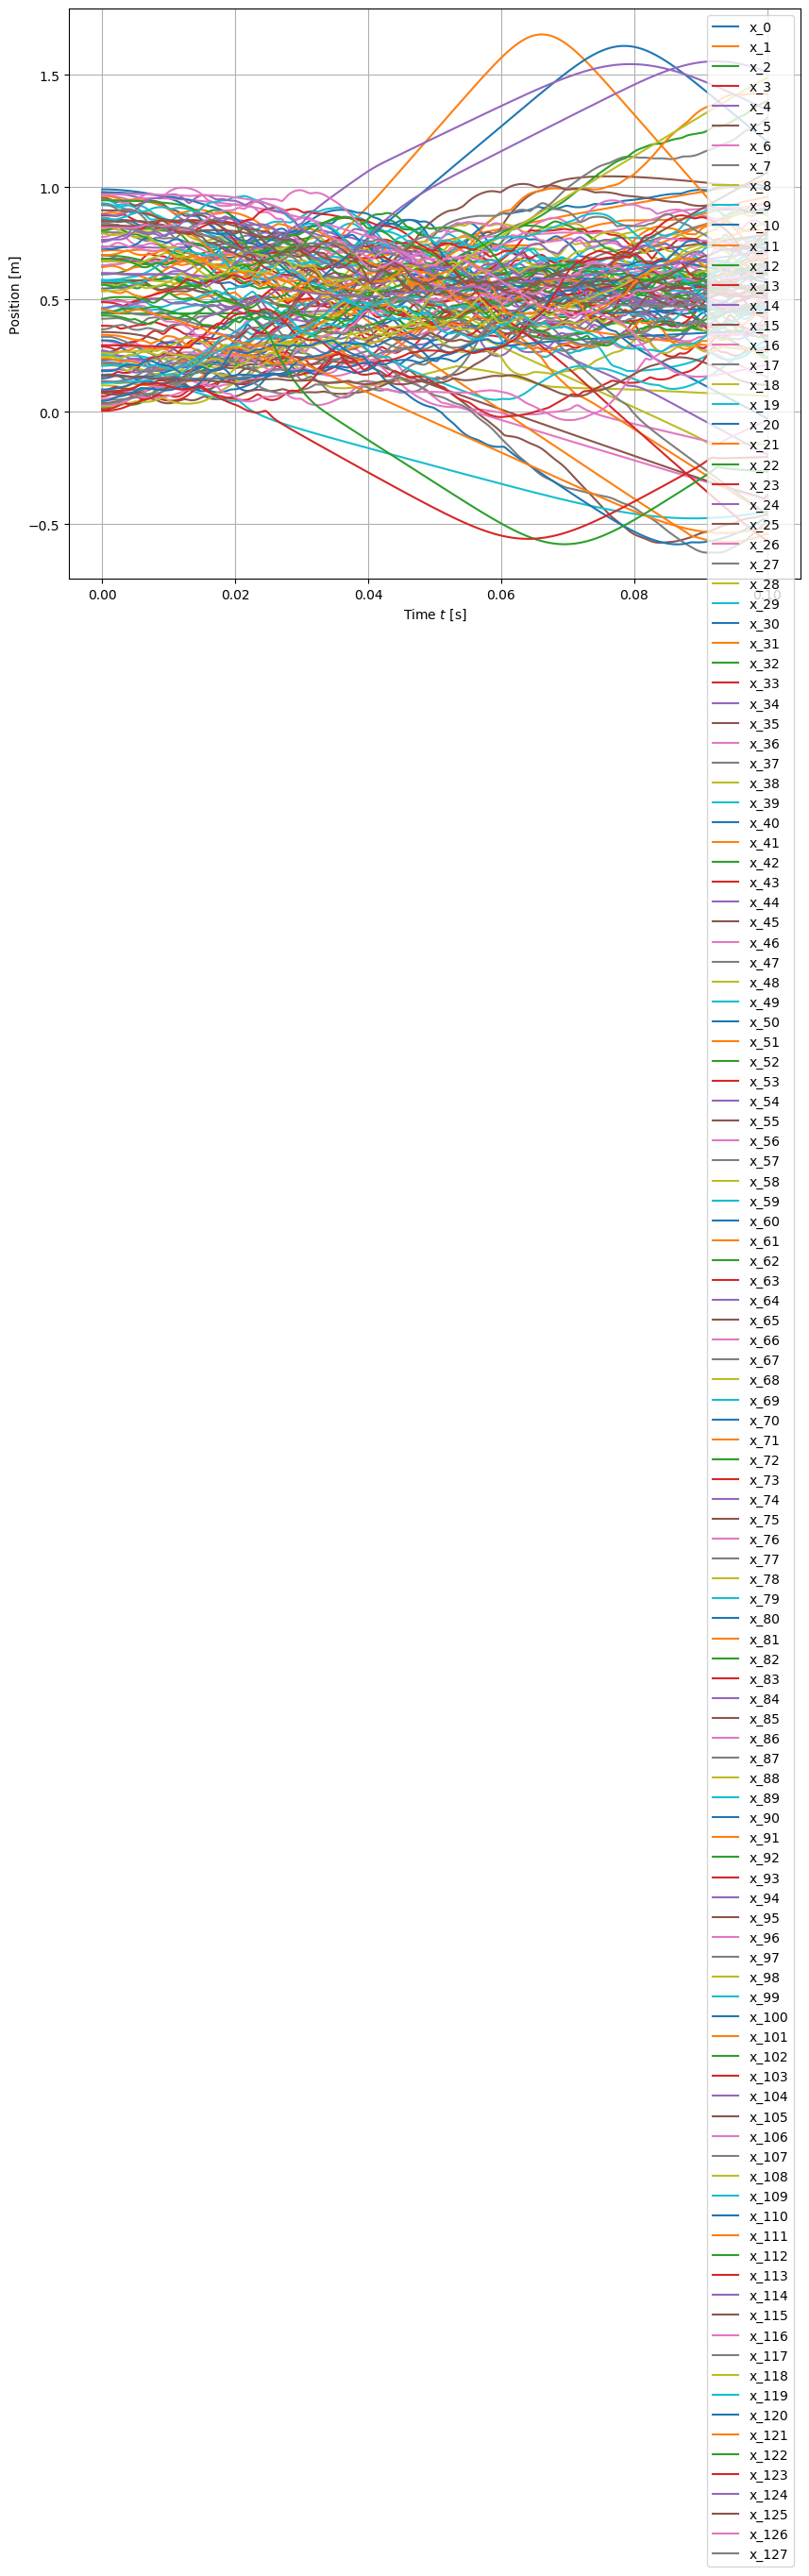

In [23]:
solution.particletracker.plot_time_trajectories('x')

In [24]:
solutions

{'njit': <xarray.Dataset>
 Dimensions:           (dimension: 3, particle: 128, time: 1001)
 Coordinates:
   * time              (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
   * particle          (particle) int64 0 1 2 3 4 5 6 ... 122 123 124 125 126 127
   * dimension         (dimension) <U1 'x' 'y' 'z'
 Data variables:
     position          (time, particle, dimension) float64 0.5488 ... 0.573
     velocity          (time, particle, dimension) float64 -0.001163 ... 19.12
     B                 (time, particle, dimension) float64 0.0 0.0 ... 0.0 0.0
     E                 (time, particle, dimension) float64 2.327e+03 ... 5.86e+04
     timestep          (time) float64 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
     kinetic_energy    (time, particle) float64 7.749e-06 8.13e-05 ... 717.0
     potential_energy  (time, particle) float64 -223.3 -324.6 ... -1.704e+03
 Attributes:
     particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)}

In [25]:
solution = solutions['njit']
import pyvista
fig = pyvista.PlotterITK()
for particle in range(N):
    solution.particletracker.visualize(fig, particle=particle, stride=10);
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [30]:
pyvista.vtk_points??

Signature: pyvista.vtk_points(points, deep=True)
Source:   
def vtk_points(points, deep=True):
    """Convert numpy points to a vtkPoints object."""
    if not points.flags['C_CONTIGUOUS']:
        points = np.ascontiguousarray(points)
    vtkpts = vtk.vtkPoints()
    vtkpts.SetData(nps.numpy_to_vtk(points, deep=deep))
    return vtkpts
File:      /progs/miniconda3/lib/python3.7/site-packages/pyvista/utilities/helpers.py
Type:      function


array([ 139.56837198,  395.16905402,  370.21472823,  739.66305903,
        389.14244587,  453.12003504,  397.06882693, 1074.34596829,
        657.30356597,  429.67707275,  268.65043358,  607.72763243,
        509.55156862,  442.72511201, 1559.82977748,  915.57695364,
        683.77375584,  372.63055679,  390.2475425 ,  453.61177104,
        486.94806114,  106.10360737, 1517.47265793,  278.55645587,
       1379.22594831,  369.76079068,  739.11757171,  217.3470191 ,
        183.69583685,  110.54616642, 1517.10757727,  240.82405237,
       1599.12748026,   47.90961415,  479.20551222,  606.21091052,
        242.82382837,   89.43744032,   70.96683797,  861.68677782,
       1585.30244625, 1618.40732803, 1057.7611358 ,  162.83881262,
       1762.72711722,  308.10266502,  161.48672655,  622.38643982,
        922.51774789,  143.05318323,  171.81825225,  254.67936521,
        531.08902842,  212.5746237 ,  521.89229775,   71.66287273,
       1652.64946556,  528.58174119,  250.31421635,  756.37708

In [49]:
pyvista.PolyData.plot?

Signature:
pyvista.PolyData.plot(
    var_item,
    off_screen=None,
    full_screen=False,
    screenshot=None,
    interactive=True,
    cpos=None,
    window_size=None,
    show_bounds=False,
    show_axes=True,
    notebook=None,
    background=None,
    text='',
    return_img=False,
    eye_dome_lighting=False,
    use_panel=None,
    volume=False,
    parallel_projection=False,
    **kwargs,
)
Docstring:
Plot a vtk or numpy object.

Parameters
----------
item : vtk or numpy object
    VTK object or numpy array to be plotted.

off_screen : bool
    Plots off screen when True.  Helpful for saving screenshots
    without a window popping up.

full_screen : bool, optional
    Opens window in full screen.  When enabled, ignores window_size.
    Default False.

screenshot : str or bool, optional
    Saves screenshot to file when enabled.  See:
    help(pyvistanterface.Plotter.screenshot).  Default disabled.

    When True, takes screenshot and returns numpy array of image.

window_siz

In [67]:
solution.position.isel(time=500)
fig = pyvista.PlotterITK()
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
points = pyvista.PolyData(solution.position.isel(time=500).values)
points['kinetic'] = solution.kinetic_energy.isel(time=500).values
fig.add_mesh(points, scalars='kinetic', eye_dome_lightning = True)
for particle in range(N):
    solution.isel(time=range(0, 500)).particletracker.visualize(fig, particle=particle)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…